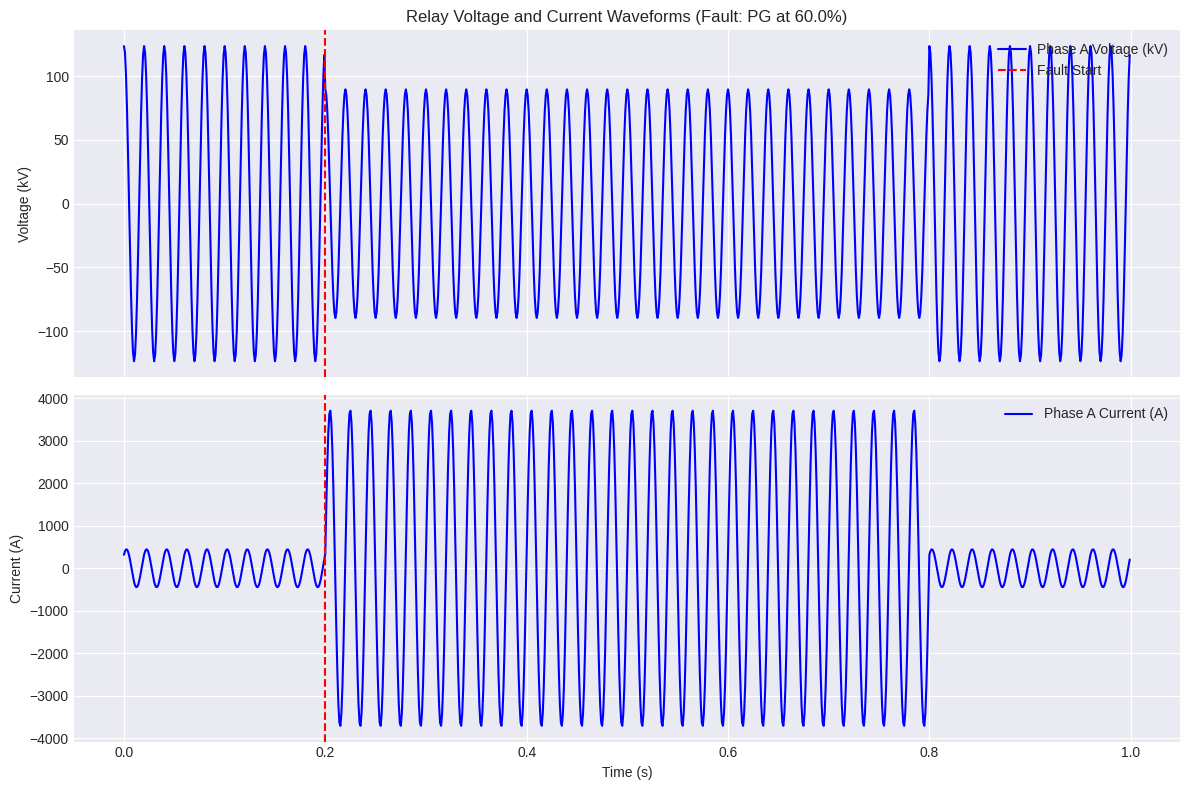

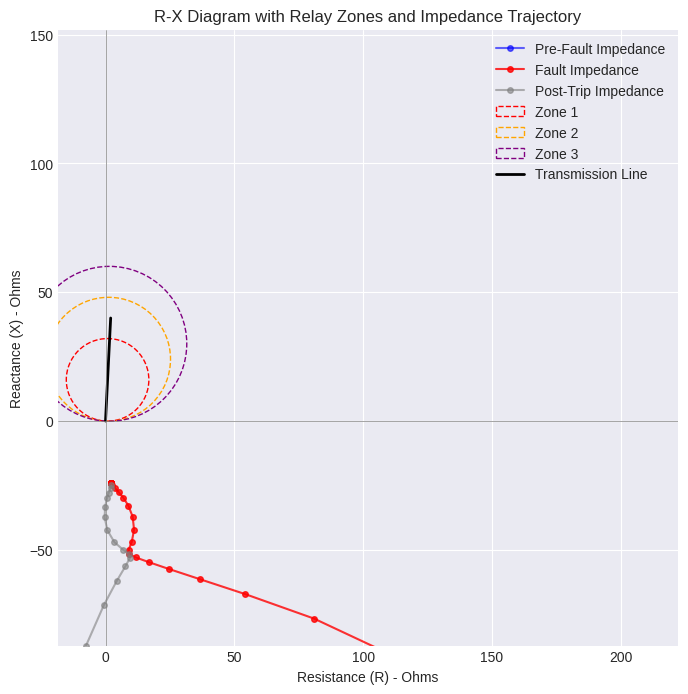


--- Simulation Summary ---
Fault Type: PG
Fault Location: 60.0% (60.0 km)
Fault Resistance: 1.0 Ohms
Fault Start Time: 0.2 s
Trip Signal: No
-------------------------


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath # For complex number operations

# --- Simulation Parameters ---
fs = 1000.0  # Sampling frequency (Hz) - Should be >= 2 * f
f = 50.0     # System frequency (Hz)
T = 1.0      # Total simulation time (s)
dt = 1.0 / fs # Time step
N_cycle = int(fs / f) # Samples per cycle for DFT window

# --- Transmission Line Parameters ---
line_length = 100.0 # km
R_line_per_km = 0.02  # Resistance per km (Ohms/km)
X_line_per_km = 0.4   # Reactance per km (Ohms/km)
Z_line_per_km = complex(R_line_per_km, X_line_per_km) # Impedance per km
Z_line_total = Z_line_per_km * line_length # Total line impedance

# --- System Parameters ---
V_source_mag = 220e3 / np.sqrt(3) # Phase voltage magnitude (V) - L-N voltage
source_angle = 0 # Source voltage angle (degrees)
Z_source = complex(1.0, 10.0) # Source impedance (Ohms)
load_impedance = complex(200, 150) # Load impedance (Ohms)

# --- Relay Settings (Mho Characteristics) ---
# Zone 1: 80% of line length, instantaneous trip
Z1_reach = 0.80 * Z_line_total
Z1_radius = abs(Z1_reach) / 2
Z1_center = Z1_reach / 2
Z1_angle = cmath.phase(Z1_reach) # Characteristic angle

# Zone 2: 120% of line length, delayed trip (e.g., 0.3s)
Z2_reach = 1.20 * Z_line_total
Z2_radius = abs(Z2_reach) / 2
Z2_center = Z2_reach / 2
Z2_delay = 0.3 # seconds

# Zone 3: 150% of line + Source Impedance consideration (simplified), delayed trip (e.g., 1.0s)
# Often looks behind the relay as well. Using a simple forward reach here.
Z3_reach = 1.50 * Z_line_total
Z3_radius = abs(Z3_reach) / 2
Z3_center = Z3_reach / 2
Z3_delay = 1.0 # seconds

# --- Fault Parameters ---
fault_type = 'PG' # 'None', 'PG' (Phase-A to Ground), 'PP' (Phase-A to Phase-B)
fault_location_perc = 0.6 # Percentage of line length from relay
fault_resistance = 1.0   # Fault resistance (Ohms)
fault_start_time = 0.2 # Time when fault occurs (s)
fault_end_time = 0.8   # Time when fault clears (s) (or breaker opens)

# --- Time Vector ---
t = np.arange(0, T, dt)
n_samples = len(t)

# --- Generate Signals ---
# Source voltage (Phase A)
v_source_a = V_source_mag * np.cos(2 * np.pi * f * t + np.radians(source_angle))
# For PP fault simulation, we need Phase B
v_source_b = V_source_mag * np.cos(2 * np.pi * f * t + np.radians(source_angle - 120))

# Initialize voltage and current at the relay location
v_relay_a = np.zeros_like(t)
i_relay_a = np.zeros_like(t)
v_relay_b = np.zeros_like(t) # Needed for PP fault
i_relay_b = np.zeros_like(t) # Needed for PP fault

# --- Simulation Loop ---
breaker_open = False
trip_signal = False
trip_time = -1
zone_tripped = 0
fault_active = False

# Pre-calculate fault impedance based on type
Z_fault = complex(fault_resistance, 0)
fault_location_km = fault_location_perc * line_length
Z_to_fault = Z_line_per_km * fault_location_km

for i in range(n_samples):
    current_time = t[i]

    # Check for fault condition
    if not breaker_open and fault_start_time <= current_time < fault_end_time:
        fault_active = True
        if fault_type == 'PG':
            # Simplified Phase-A to Ground Fault Calculation
            # Total impedance = Z_source + Z_to_fault + Z_fault
            Z_total_fault = Z_source + Z_to_fault + Z_fault
            I_fault_a = (V_source_mag * cmath.exp(1j * np.radians(source_angle))) / Z_total_fault
            V_fault_a = I_fault_a * (Z_to_fault + Z_fault)

            # Calculate instantaneous values at relay
            i_relay_a[i] = abs(I_fault_a) * np.cos(2 * np.pi * f * current_time + cmath.phase(I_fault_a))
            v_relay_a[i] = abs(V_fault_a) * np.cos(2 * np.pi * f * current_time + cmath.phase(V_fault_a))
            # Phase B remains relatively normal (simplified) - load current decreases
            Z_total_normal = Z_source + Z_line_total + load_impedance
            I_normal_b = (V_source_mag * cmath.exp(1j * np.radians(source_angle - 120))) / Z_total_normal
            i_relay_b[i] = abs(I_normal_b) * np.cos(2 * np.pi * f * current_time + cmath.phase(I_normal_b) - np.pi*2/3)
            v_relay_b[i] = v_source_b[i] - i_relay_b[i] * Z_source.real # Simplified voltage drop

        elif fault_type == 'PP':
             # Simplified Phase-A to Phase-B Fault Calculation
             # Vab = Va - Vb
             Vab_source = (V_source_mag * cmath.exp(1j * np.radians(source_angle))) - \
                          (V_source_mag * cmath.exp(1j * np.radians(source_angle - 120)))
             # Impedance path: Zs_a + Zline_a_fault + Zf + Zline_b_fault + Zs_b (assuming symmetrical source)
             Z_total_fault = 2 * Z_source + 2 * Z_to_fault + Z_fault
             I_fault_ab = Vab_source / Z_total_fault # This is the loop current
             I_fault_a = I_fault_ab
             I_fault_b = -I_fault_ab # Current leaves B, enters A

             # Voltage at relay: V_relay_a = V_source_a - I_fault_a * Z_source
             V_relay_fault_a = (V_source_mag * cmath.exp(1j * np.radians(source_angle))) - I_fault_a * Z_source
             V_relay_fault_b = (V_source_mag * cmath.exp(1j * np.radians(source_angle-120))) - I_fault_b * Z_source

             # Calculate instantaneous values
             i_relay_a[i] = abs(I_fault_a) * np.cos(2 * np.pi * f * current_time + cmath.phase(I_fault_a))
             i_relay_b[i] = abs(I_fault_b) * np.cos(2 * np.pi * f * current_time + cmath.phase(I_fault_b))
             v_relay_a[i] = abs(V_relay_fault_a) * np.cos(2 * np.pi * f * current_time + cmath.phase(V_relay_fault_a))
             v_relay_b[i] = abs(V_relay_fault_b) * np.cos(2 * np.pi * f * current_time + cmath.phase(V_relay_fault_b))

        else: # Normal operation or fault cleared
            fault_active = False
            # Normal Load Flow
            Z_total_normal = Z_source + Z_line_total + load_impedance
            I_load_a = (V_source_mag * cmath.exp(1j * np.radians(source_angle))) / Z_total_normal
            V_relay_normal_a = I_load_a * (Z_line_total + load_impedance)

            i_relay_a[i] = abs(I_load_a) * np.cos(2 * np.pi * f * current_time + cmath.phase(I_load_a))
            v_relay_a[i] = abs(V_relay_normal_a) * np.cos(2 * np.pi * f * current_time + cmath.phase(V_relay_normal_a))
            # Phase B normal load
            I_load_b = (V_source_mag * cmath.exp(1j * np.radians(source_angle - 120))) / Z_total_normal
            V_relay_normal_b = I_load_b * (Z_line_total + load_impedance)
            i_relay_b[i] = abs(I_load_b) * np.cos(2 * np.pi * f * current_time + cmath.phase(I_load_b))
            v_relay_b[i] = abs(V_relay_normal_b) * np.cos(2 * np.pi * f * current_time + cmath.phase(V_relay_normal_b))

    elif breaker_open:
        # Breaker is open, current should be zero (ideal breaker)
        fault_active = False
        i_relay_a[i] = 0
        i_relay_b[i] = 0
        # Voltage might be source voltage or line-side voltage depending on specifics
        # Here, assume relay sees source side voltage after opening (simplified)
        v_relay_a[i] = v_source_a[i]
        v_relay_b[i] = v_source_b[i]
    else:
        # Normal operation before fault or after fault clears naturally
        fault_active = False
        Z_total_normal = Z_source + Z_line_total + load_impedance
        I_load_a = (V_source_mag * cmath.exp(1j * np.radians(source_angle))) / Z_total_normal
        V_relay_normal_a = I_load_a * (Z_line_total + load_impedance)
        i_relay_a[i] = abs(I_load_a) * np.cos(2 * np.pi * f * current_time + cmath.phase(I_load_a))
        v_relay_a[i] = abs(V_relay_normal_a) * np.cos(2 * np.pi * f * current_time + cmath.phase(V_relay_normal_a))
        # Phase B normal load
        I_load_b = (V_source_mag * cmath.exp(1j * np.radians(source_angle - 120))) / Z_total_normal
        V_relay_normal_b = I_load_b * (Z_line_total + load_impedance)
        i_relay_b[i] = abs(I_load_b) * np.cos(2 * np.pi * f * current_time + cmath.phase(I_load_b))
        v_relay_b[i] = abs(V_relay_normal_b) * np.cos(2 * np.pi * f * current_time + cmath.phase(V_relay_normal_b))


# --- Phasor Estimation using DFT ---
V_phasors_a = []
I_phasors_a = []
V_phasors_b = [] # For PP
I_phasors_b = [] # For PP
impedances = []
times_for_phasors = []

# DFT function for fundamental component
def calculate_phasor_dft(signal_window, N_cycle):
    """Calculates the phasor (complex) of the fundamental frequency using DFT."""
    if len(signal_window) < N_cycle:
        return complex(0, 0)
    # Apply DFT for the fundamental frequency (k=1 for DC=0, Fund=1)
    # X_k = sum_{n=0}^{N-1} x_n * exp(-j * 2 * pi * k * n / N)
    # We want the component at frequency f, which corresponds to k=1 if N=N_cycle
    k = 1
    dft_val = np.sum(signal_window * np.exp(-1j * 2 * np.pi * k * np.arange(N_cycle) / N_cycle))
    # Scale and adjust phase for cosine reference
    # Phasor = (2/N) * X_k* . For cosine ref, we take the complex conjugate X_k^*
    # and the magnitude needs to be divided by sqrt(2) for RMS
    phasor = (np.sqrt(2) / N_cycle) * dft_val.conjugate() # RMS Phasor for cosine ref
    #phasor = (2.0 / N_cycle) * dft_val.conjugate() # Peak Phasor for cosine ref
    return phasor


# Calculate phasors and impedance using a sliding window
for i in range(N_cycle - 1, n_samples):
    # Get the window for the last cycle
    v_window_a = v_relay_a[i - N_cycle + 1 : i + 1]
    i_window_a = i_relay_a[i - N_cycle + 1 : i + 1]
    v_window_b = v_relay_b[i - N_cycle + 1 : i + 1] # For PP
    i_window_b = i_relay_b[i - N_cycle + 1 : i + 1] # For PP

    # Calculate phasors using DFT
    V_a = calculate_phasor_dft(v_window_a, N_cycle)
    I_a = calculate_phasor_dft(i_window_a, N_cycle)
    V_b = calculate_phasor_dft(v_window_b, N_cycle) # For PP
    I_b = calculate_phasor_dft(i_window_b, N_cycle) # For PP

    V_phasors_a.append(V_a)
    I_phasors_a.append(I_a)
    V_phasors_b.append(V_b)
    I_phasors_b.append(I_b)
    times_for_phasors.append(t[i]) # Time corresponding to the end of the window

    # Calculate apparent impedance based on fault type
    Z_app = complex(np.inf, np.inf) # Default to infinity if calculation fails
    if fault_type == 'PG' or not fault_active: # Use phase A for PG or normal
        if abs(I_a) > 1e-3: # Avoid division by zero or small currents
            Z_app = V_a / I_a
    elif fault_type == 'PP' and fault_active:
         # For PP fault, use Vab / (Ia - Ib)
         V_ab = V_a - V_b
         I_diff = I_a - I_b
         if abs(I_diff) > 1e-3:
             Z_app = V_ab / I_diff

    impedances.append(Z_app)

# Convert lists to numpy arrays for easier handling
impedances = np.array(impedances)
times_for_phasors = np.array(times_for_phasors)

# --- Trip Logic ---
trip_times = []
trip_zones = []
trip_impedances = []
fault_distances = []

trip_timer_z2 = 0
trip_timer_z3 = 0
tripped_this_fault = False # Reset trip status for each fault instance simulation

for i in range(len(impedances)):
    Z = impedances[i]
    current_time = times_for_phasors[i]

    # Check if already tripped by this fault event or if breaker is open
    if tripped_this_fault or current_time >= fault_end_time: # Assume breaker opened at fault_end_time if tripped
        continue

    # Check Zone 1 (Mho Circle: |Z - Z1_center| <= Z1_radius)
    # More robust check: Z is within the circle AND angle is close to line angle
    if abs(Z - Z1_center) <= Z1_radius and abs(cmath.phase(Z) - Z1_angle) < np.pi/4 : # Check angle roughly
        trip_signal = True
        trip_time = current_time
        zone_tripped = 1
        breaker_open = True # Instantaneous trip
        fault_end_time = trip_time # Breaker opens now
        tripped_this_fault = True
        print(f"--- TRIP --- Zone 1 detected at t = {trip_time:.4f} s")
        trip_times.append(trip_time)
        trip_zones.append(zone_tripped)
        trip_impedances.append(Z)
        # Estimate distance
        dist = Z.imag / X_line_per_km if X_line_per_km != 0 else 0
        fault_distances.append(dist)
        print(f"             Impedance: {Z.real:.2f} + {Z.imag:.2f}j Ohms")
        print(f"             Estimated Fault Distance: {dist:.2f} km")
        continue # Don't check other zones if Z1 trips

    # Check Zone 2
    if abs(Z - Z2_center) <= Z2_radius and abs(cmath.phase(Z) - Z1_angle) < np.pi/3:
        trip_timer_z2 += dt # Increment timer only when inside zone
        if trip_timer_z2 >= Z2_delay:
            trip_signal = True
            trip_time = current_time
            zone_tripped = 2
            breaker_open = True # Delayed trip
            fault_end_time = trip_time # Breaker opens now
            tripped_this_fault = True
            print(f"--- TRIP --- Zone 2 detected at t = {trip_time:.4f} s (after delay)")
            trip_times.append(trip_time)
            trip_zones.append(zone_tripped)
            trip_impedances.append(Z)
            dist = Z.imag / X_line_per_km if X_line_per_km != 0 else 0
            fault_distances.append(dist)
            print(f"             Impedance: {Z.real:.2f} + {Z.imag:.2f}j Ohms")
            print(f"             Estimated Fault Distance: {dist:.2f} km")
            continue
    else:
         trip_timer_z2 = 0 # Reset timer if impedance moves out

    # Check Zone 3
    if abs(Z - Z3_center) <= Z3_radius and abs(cmath.phase(Z) - Z1_angle) < np.pi/2:
        trip_timer_z3 += dt
        if trip_timer_z3 >= Z3_delay:
            trip_signal = True
            trip_time = current_time
            zone_tripped = 3
            breaker_open = True # Delayed trip
            fault_end_time = trip_time # Breaker opens now
            tripped_this_fault = True
            print(f"--- TRIP --- Zone 3 detected at t = {trip_time:.4f} s (after delay)")
            trip_times.append(trip_time)
            trip_zones.append(zone_tripped)
            trip_impedances.append(Z)
            dist = Z.imag / X_line_per_km if X_line_per_km != 0 else 0
            fault_distances.append(dist)
            print(f"             Impedance: {Z.real:.2f} + {Z.imag:.2f}j Ohms")
            print(f"             Estimated Fault Distance: {dist:.2f} km")
            continue
    else:
        trip_timer_z3 = 0 # Reset timer

# --- Plotting ---
plt.style.use('seaborn-v0_8-darkgrid') # Use a nice style

# 1. Voltage and Current Waveforms
fig1, axs1 = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axs1[0].plot(t, v_relay_a / 1000, label='Phase A Voltage (kV)', color='blue')
if fault_type == 'PP':
    axs1[0].plot(t, v_relay_b / 1000, label='Phase B Voltage (kV)', color='red', linestyle='--')
axs1[0].set_ylabel('Voltage (kV)')
axs1[0].set_title(f'Relay Voltage and Current Waveforms (Fault: {fault_type} at {fault_location_perc*100}%)')
axs1[0].axvline(fault_start_time, color='r', linestyle='--', label='Fault Start')
if trip_signal:
    axs1[0].axvline(trip_time, color='g', linestyle='--', label=f'Trip (Zone {zone_tripped})')
axs1[0].legend(loc='upper right')
axs1[0].grid(True)

axs1[1].plot(t, i_relay_a, label='Phase A Current (A)', color='blue')
if fault_type == 'PP':
     axs1[1].plot(t, i_relay_b, label='Phase B Current (A)', color='red', linestyle='--')
axs1[1].set_ylabel('Current (A)')
axs1[1].set_xlabel('Time (s)')
axs1[1].axvline(fault_start_time, color='r', linestyle='--')
if trip_signal:
    axs1[1].axvline(trip_time, color='g', linestyle='--')
axs1[1].legend(loc='upper right')
axs1[1].grid(True)
fig1.tight_layout()

# 2. R-X Diagram
fig2, ax2 = plt.subplots(figsize=(8, 8))

# Plot impedance trajectory
# Separate pre-fault, fault, and post-fault points for clarity
fault_start_index = np.searchsorted(times_for_phasors, fault_start_time, side='left')
fault_end_index = np.searchsorted(times_for_phasors, fault_end_time, side='left')

# Pre-fault impedance (load)
ax2.plot(impedances[:fault_start_index].real, impedances[:fault_start_index].imag,
         'o-', label='Pre-Fault Impedance', markersize=4, color='blue', alpha=0.6)

# Fault impedance
ax2.plot(impedances[fault_start_index:fault_end_index].real, impedances[fault_start_index:fault_end_index].imag,
         'o-', label='Fault Impedance', markersize=4, color='red', alpha=0.8)

# Post-fault impedance (if any, could be load or open circuit depending on simulation)
if fault_end_index < len(impedances):
    ax2.plot(impedances[fault_end_index:].real, impedances[fault_end_index:].imag,
             'o-', label='Post-Trip Impedance', markersize=4, color='grey', alpha=0.6)

# Plot the tripped point if a trip occurred
if trip_signal:
    ax2.plot(trip_impedances[-1].real, trip_impedances[-1].imag, 'X', markersize=12, color='lime',
             label=f'Trip Point (Zone {zone_tripped})')


# Plot Mho Circles for Zones
# Zone 1
circle1 = plt.Circle((Z1_center.real, Z1_center.imag), Z1_radius, color='red', fill=False, linestyle='--', label='Zone 1')
ax2.add_patch(circle1)
# Zone 2
circle2 = plt.Circle((Z2_center.real, Z2_center.imag), Z2_radius, color='orange', fill=False, linestyle='--', label='Zone 2')
ax2.add_patch(circle2)
# Zone 3
circle3 = plt.Circle((Z3_center.real, Z3_center.imag), Z3_radius, color='purple', fill=False, linestyle='--', label='Zone 3')
ax2.add_patch(circle3)

# Plot the line impedance
ax2.plot([0, Z_line_total.real], [0, Z_line_total.imag], 'k-', lw=2, label='Transmission Line')

ax2.set_xlabel('Resistance (R) - Ohms')
ax2.set_ylabel('Reactance (X) - Ohms')
ax2.set_title('R-X Diagram with Relay Zones and Impedance Trajectory')
ax2.axhline(0, color='grey', lw=0.5)
ax2.axvline(0, color='grey', lw=0.5)
ax2.grid(True)
ax2.legend()
ax2.axis('equal') # Ensure circles look like circles

# Set reasonable limits based on zones and trajectory
max_r = max(Z3_reach.real * 1.2, np.max(impedances.real[np.isfinite(impedances.real)]) * 1.1, 10)
max_x = max(Z3_reach.imag * 1.2, np.max(impedances.imag[np.isfinite(impedances.imag)]) * 1.1, 10)
min_r = min(Z1_center.real - Z1_radius * 1.2, np.min(impedances.real[np.isfinite(impedances.real)]) * 1.1, -10)
min_x = -max_x * 0.1 # Usually don't need much negative reactance display

ax2.set_xlim(min(min_r, -5), max_r)
ax2.set_ylim(min(min_x, -5), max_x)


plt.show()

print("\n--- Simulation Summary ---")
print(f"Fault Type: {fault_type}")
print(f"Fault Location: {fault_location_perc*100:.1f}% ({fault_location_km:.1f} km)")
print(f"Fault Resistance: {fault_resistance} Ohms")
print(f"Fault Start Time: {fault_start_time} s")
if trip_signal:
    print(f"Trip Signal: Yes")
    print(f"Trip Time: {trip_times[-1]:.4f} s")
    print(f"Tripped Zone: {trip_zones[-1]}")
    print(f"Impedance at Trip: {trip_impedances[-1].real:.2f} + {trip_impedances[-1].imag:.2f}j Ohms")
    print(f"Estimated Fault Distance: {fault_distances[-1]:.2f} km")
else:
    print("Trip Signal: No")
print("-------------------------")
